In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras   # J: this is the machine learning
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, concatenate, Masking, LSTM, TimeDistributed, Lambda, Reshape, Multiply, BatchNormalization, Bidirectional
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
import h5py   # J: this is for the type of input data files
import os 
from clr_callback import *   # J: I had to download a py file from Github for this
from tensorflow.keras.callbacks import TensorBoard
import tensorflow.keras.backend as K  
from tensorflow.keras.optimizers import * 
import glob
import re
import importlib 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Required python scripts and files 
X_maxmean = np.load('X_maxmean_new.npy')       # J: list of mean and max for the 43 variables? But how is it produced?
Y_maxmean = np.load('Y_maxmean_new.npy')
import normalize
import shape_timesteps
importlib.reload(normalize)
importlib.reload(shape_timesteps)

# J: added this because it needs to be defined
def loss_fc(true, pred):
        return K.mean(K.square(true-pred)*(1+3*K.square(K.abs(true))))


# Parameters ============================================================================
# Path to h5 file
#name = './../../../../../data/hongtao/inputs_2021-02-05/variables_tt_rmu_padded.h5'
name = './test_inputs.h5'    # J: this is my input file, although it may be made wrong
#name = '/data/jchishol/variables_tt_rmu_padded.h5'   # J: this is his input file
# prediction save file
pred_name = 'preds.npy'
# true save file
true_name = 'true.npy'
# Predictions are saved in a (#samples)x20 array, with 
# ['th_pt', 'th_eta','th_phi','th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m']
# ordering
# =======================================================================================

name0 = os.path.basename(name)
name0 = re.sub('\.h5$', '', name0)
dataset = h5py.File(name,'r')
# ['j1_pt', 'j1_eta', 'j1_phi', 'j1_x', 'j1_y', 'j1_z', 'j1_m', 'j1_e', 'j1_DL1r', 'j1_isbtag', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_x', 'j2_y', 'j2_z', 'j2_m', 'j2_e', 'j2_DL1r', 'j2_isbtag', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_x', 'j3_y', 'j3_z', 'j3_m', 'j3_e', 'j3_DL1r', 'j3_isbtag', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_x', 'j4_y', 'j4_z', 'j4_m', 'j4_e', 'j4_DL1r', 'j4_isbtag', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_x', 'j5_y', 'j5_z', 'j5_m', 'j5_e', 'j5_DL1r', 'j5_isbtag', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_x', 'j6_y', 'j6_z', 'j6_m', 'j6_e', 'j6_DL1r', 'j6_isbtag', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_x', 'lep_y', 'lep_z', 'lep_e', 'met_met', 'met_phi']
size = np.array(dataset.get('th_pt')).size
X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
Y_keys = ['th_pt', 'th_eta','th_phi','th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m']

phi_keys = list(filter(lambda a: 'phi' in a, dataset.keys()))
eta_keys = list(filter(lambda a: 'eta' in a, dataset.keys()))
pt_keys =  list(filter(lambda a: 'pt' in a, dataset.keys()))
m_keys = list(filter(lambda a: 'm' in a, dataset.keys()))
DL1r_keys = list(filter(lambda a: 'DL1r' in a, dataset.keys()))

Y_length = len(Y_keys)
X_length = len(X_keys)
crop0 =  size

# J: these lines pre-process the data (i.e. scaling, getting px, py, etc.)
Scaler = normalize.Scale_variables()
X_total, X_names = Scaler.scale_arrays(X_keys, X_maxmean)
Y_total, Y_names = Scaler.scale_arrays(Y_keys, Y_maxmean)

# J: I want to see what's here
print ('X names:')
print (X_names)
print ('Y names:')
print (Y_names)

# print('Max scaling error: {}'.format(error))

# Create X and test array
split = int(np.floor(0.95*crop0)) 
split = 0 

# J: splitting truth data into some for training ML and some for testing ML
trainY, testY = Y_total[0:split,:], Y_total[split:,:]

# J: no idea what this does, maybe splits jets and other variables???
timestep_builder = shape_timesteps.Shape_timesteps()
totalX_jets, totalX_other = timestep_builder.reshape_X(X_total, X_names, False,True)

# J: again, splitting reco data into some for training and some for testing (this time by jets and by other)
trainX_jets, testX_jets = totalX_jets[0:split,:,:], totalX_jets[split:,:,:]
trainX_other, testX_other = totalX_other[0:split,:], totalX_other[split:,:]
print(testX_jets.shape, testX_other.shape, testY.shape)

if testX_jets.shape[0] > 0: 
    other_bins = np.linspace(-1, 1, 40)
    phi_bins = np.linspace(-1, 1, 40)
    pt_bins = np.linspace(-1, 1, 40)
    Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

    #model = keras.models.load_model('./../runs/12-3-clean.keras', custom_objects={'loss_fc':loss_fc})
    model = keras.models.load_model('./model.keras', custom_objects={'loss_fc':loss_fc})  # J: maybe this model idk

    # J: making a prediction, but I don't feel like we've used the training data at all ...
    # J: this doesn't even seem to be used later so idk the point
    predictions_unscaled = model.predict([testX_jets, testX_other])
    true_unscaled = testY 

    # J: okay this ones seems to use both training and testing data?
    total_predictions = model.predict([np.append(trainX_jets,testX_jets,axis=0), np.append(trainX_other,testX_other,axis=0)])
    Y_total, _ = Scaler.scale_arrays(Y_keys, Y_maxmean)  # J: didn't we already do this?

    # J: I think this undoes the scaling we did in the pre-processing earlier
    predictions_origscale = Scaler.invscale_arrays(total_predictions, Y_names, Y_maxmean)[split:,:]
    true_origscale = Scaler.invscale_arrays(Y_total, Y_names, Y_maxmean)[split:,:]

    # J: save predictions and truth
    np.save(pred_name, predictions_origscale)
    np.save(true_name, true_origscale)
else:
    print('skip')
dataset.close()

43
984641
20
984641
X names:
['j1_ptbox', 'j1_px', 'j1_py', 'j1_eta', 'j1_m', 'j1_DL1r', 'j2_ptbox', 'j2_px', 'j2_py', 'j2_eta', 'j2_m', 'j2_DL1r', 'j3_ptbox', 'j3_px', 'j3_py', 'j3_eta', 'j3_m', 'j3_DL1r', 'j4_ptbox', 'j4_px', 'j4_py', 'j4_eta', 'j4_m', 'j4_DL1r', 'j5_ptbox', 'j5_px', 'j5_py', 'j5_eta', 'j5_m', 'j5_DL1r', 'j6_ptbox', 'j6_px', 'j6_py', 'j6_eta', 'j6_m', 'j6_DL1r', 'lep_ptbox', 'lep_px', 'lep_py', 'lep_eta', 'met_met', 'met_phi-sin', 'met_phi-cos']
Y names:
['th_ptbox', 'th_px', 'th_py', 'th_eta', 'th_m', 'wh_ptbox', 'wh_px', 'wh_py', 'wh_eta', 'wh_m', 'tl_ptbox', 'tl_px', 'tl_py', 'tl_eta', 'tl_m', 'wl_ptbox', 'wl_px', 'wl_py', 'wl_eta', 'wl_m']


/home/jchishol/TRecNet/normalize.py:17: RuntimeWarning: invalid value encountered in true_divide
  z = (array - maxmean0[:,1])/maxmean0[:,0]


(984641, 6, 6) (984641, 7) (984641, 20)
20
984641


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, concatenate, Masking, LSTM, TimeDistributed, Lambda, Reshape, Multiply, BatchNormalization, Bidirectional
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
import h5py 
import os 
from clr_callback import *
from tensorflow.keras.callbacks import TensorBoard
import tensorflow.keras.backend as K  
from tensorflow.keras.optimizers import * 
import glob
import re
import importlib 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

%matplotlib inline 

# J: glob.glob just makes an array of all file paths with this name
#names = glob.glob("./../../../../../data/hongtao/inputs_2021-02-05/*_padded.h5")
def loss_fc(true, pred):
        return K.mean(K.square(true-pred)*(1+3*K.square(K.abs(true))))
#names.remove('./../../../../../data/hongtao/inputs_2021-02-05/variables_tt_rmu_padded.h5')
#names.remove('./../../../../../data/hongtao/inputs_2021-02-05/variables_tt_re_padded.h5')

# J: had to improvise to get this block to work with only one file
names = ['./../test_inputs.h5']

for name in names:
    # name = re.sub('\_padded.h5$', '', name)+'.h5'
    name0 = os.path.basename(name)
    name0 = re.sub('\.h5$', '', name0)
    dataset = h5py.File(name,'r')
    # ['j1_pt', 'j1_eta', 'j1_phi', 'j1_x', 'j1_y', 'j1_z', 'j1_m', 'j1_e', 'j1_DL1r', 'j1_isbtag', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_x', 'j2_y', 'j2_z', 'j2_m', 'j2_e', 'j2_DL1r', 'j2_isbtag', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_x', 'j3_y', 'j3_z', 'j3_m', 'j3_e', 'j3_DL1r', 'j3_isbtag', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_x', 'j4_y', 'j4_z', 'j4_m', 'j4_e', 'j4_DL1r', 'j4_isbtag', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_x', 'j5_y', 'j5_z', 'j5_m', 'j5_e', 'j5_DL1r', 'j5_isbtag', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_x', 'j6_y', 'j6_z', 'j6_m', 'j6_e', 'j6_DL1r', 'j6_isbtag', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_x', 'lep_y', 'lep_z', 'lep_e', 'met_met', 'met_phi']
    size = np.array(dataset.get('th_pt')).size
    X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
    Y_keys = ['th_pt', 'th_eta','th_phi','th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m']

    phi_keys = list(filter(lambda a: 'phi' in a, dataset.keys()))
    eta_keys = list(filter(lambda a: 'eta' in a, dataset.keys()))
    pt_keys =  list(filter(lambda a: 'pt' in a, dataset.keys()))
    m_keys = list(filter(lambda a: 'm' in a, dataset.keys()))
    DL1r_keys = list(filter(lambda a: 'DL1r' in a, dataset.keys()))

    Y_length = len(Y_keys)
    X_length = len(X_keys)
    crop0 =  size
    print(name)

    #X_maxmean = np.load('saved/X_maxmean1.npy')
    #Y_maxmean = np.load('saved/Y_maxmean1.npy')
    X_maxmean = np.load('X_maxmean1.npy')
    Y_maxmean = np.load('Y_maxmean1.npy')

    import normalize
    importlib.reload(normalize)
    import shape_timesteps
    importlib.reload(shape_timesteps)

    Scaler = normalize.Scale_variables()
    X_total, X_names = Scaler.scale_arrays(X_keys, X_maxmean)
    Y_total, Y_names = Scaler.scale_arrays(Y_keys, Y_maxmean)

    # print('Max scaling error: {}'.format(error))

    # Create X and test array
    split = int(np.floor(0.95*crop0)) 
    split = 0 

    trainY, testY = Y_total[0:split,:], Y_total[split:,:]

    timestep_builder = shape_timesteps.Shape_timesteps()

    totalX_jets, totalX_other = timestep_builder.reshape_X(X_total, X_names, False,True)

    trainX_jets, testX_jets = totalX_jets[0:split,:,:], totalX_jets[split:,:,:]
    trainX_other, testX_other = totalX_other[0:split,:], totalX_other[split:,:]
    print(testX_jets.shape, testX_other.shape, testY.shape)
    
    if testX_jets.shape[0] > 0: 
        other_bins = np.linspace(-1, 1, 40)
        phi_bins = np.linspace(-1, 1, 40)
        pt_bins = np.linspace(-1, 1, 40)
        Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

        #model = keras.models.load_model('12-3-clean.keras', custom_objects={'loss_fc':loss_fc})
        model = keras.models.load_model('model.keras', custom_objects={'loss_fc':loss_fc})
        
        predictions_unscaled = model.predict([testX_jets, testX_other])
        true_unscaled = testY 

        total_predictions = model.predict([np.append(trainX_jets,testX_jets,axis=0), np.append(trainX_other,testX_other,axis=0)])
        Y_total, _ = Scaler.scale_arrays(Y_keys, Y_maxmean)

        predictions_origscale = Scaler.invscale_arrays(total_predictions, Y_names, Y_maxmean)[split:,:]
        true_origscale = Scaler.invscale_arrays(Y_total, Y_names, Y_maxmean)[split:,:]

        #np.save('saved/13-3-2021/'+name0+'', predictions_origscale)
        #np.save('saved/13-3-2021/'+name0+'-true', true_origscale)
        np.save(name0+'', predictions_origscale)
        np.save(name0+'-true', true_origscale)
    else:
        print('skip')
    dataset.close()


./../test_inputs.h5
(984641, 6, 6) (984641, 7) (984641, 20)


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, concatenate, Masking, LSTM, TimeDistributed, Lambda, Reshape, Multiply, BatchNormalization, Bidirectional
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
import h5py 
import os 
from clr_callback import *
from tensorflow.keras.callbacks import TensorBoard
import tensorflow.keras.backend as K  
from tensorflow.keras.optimizers import * 
import glob
import re
import importlib 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

%matplotlib inline 

names = glob.glob("./../../../../../data/hongtao/inputs_2021-02-05/*_padded.h5")
def loss_fc(true, pred):
        return K.mean(K.square(true-pred)*(1+3*K.square(K.abs(true))))

names.remove('./../../../../../data/hongtao/inputs_2021-02-05/variables_tt_rmu_padded.h5')
names.remove('./../../../../../data/hongtao/inputs_2021-02-05/variables_tt_re_padded.h5')

for name in names:
    name = re.sub('\_padded.h5$', '', name)+'.h5'
    name0 = os.path.basename(name)
    name0 = re.sub('\.h5$', '', name0)
    dataset = h5py.File(name,'r')
    # ['j1_pt', 'j1_eta', 'j1_phi', 'j1_x', 'j1_y', 'j1_z', 'j1_m', 'j1_e', 'j1_DL1r', 'j1_isbtag', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_x', 'j2_y', 'j2_z', 'j2_m', 'j2_e', 'j2_DL1r', 'j2_isbtag', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_x', 'j3_y', 'j3_z', 'j3_m', 'j3_e', 'j3_DL1r', 'j3_isbtag', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_x', 'j4_y', 'j4_z', 'j4_m', 'j4_e', 'j4_DL1r', 'j4_isbtag', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_x', 'j5_y', 'j5_z', 'j5_m', 'j5_e', 'j5_DL1r', 'j5_isbtag', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_x', 'j6_y', 'j6_z', 'j6_m', 'j6_e', 'j6_DL1r', 'j6_isbtag', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_x', 'lep_y', 'lep_z', 'lep_e', 'met_met', 'met_phi']
    size = np.array(dataset.get('th_pt')).size
    X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
    Y_keys = ['th_pt', 'th_eta','th_phi','th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m']

    phi_keys = list(filter(lambda a: 'phi' in a, dataset.keys()))
    eta_keys = list(filter(lambda a: 'eta' in a, dataset.keys()))
    pt_keys =  list(filter(lambda a: 'pt' in a, dataset.keys()))
    m_keys = list(filter(lambda a: 'm' in a, dataset.keys()))
    DL1r_keys = list(filter(lambda a: 'DL1r' in a, dataset.keys()))

    Y_length = len(Y_keys)
    X_length = len(X_keys)
    crop0 =  size
    print(name)

    X_maxmean = np.load('saved/X_maxmean1.npy')
    Y_maxmean = np.load('saved/Y_maxmean1.npy')

    import normalize
    importlib.reload(normalize)
    import shape_timesteps
    importlib.reload(shape_timesteps)

    Scaler = normalize.Scale_variables()
    X_total, X_names = Scaler.scale_arrays(X_keys, X_maxmean)
    Y_total, Y_names = Scaler.scale_arrays(Y_keys, Y_maxmean)

    # print('Max scaling error: {}'.format(error))

    # Create X and test array
    split = int(np.floor(0.95*crop0)) 
    split = 0 

    trainY, testY = Y_total[0:split,:], Y_total[split:,:]

    timestep_builder = shape_timesteps.Shape_timesteps()

    totalX_jets, totalX_other = timestep_builder.reshape_X(X_total, X_names, False,True)

    trainX_jets, testX_jets = totalX_jets[0:split,:,:], totalX_jets[split:,:,:]
    trainX_other, testX_other = totalX_other[0:split,:], totalX_other[split:,:]
    print(testX_jets.shape, testX_other.shape, testY.shape)
    
    if testX_jets.shape[0] > 0: 
        other_bins = np.linspace(-1, 1, 40)
        phi_bins = np.linspace(-1, 1, 40)
        pt_bins = np.linspace(-1, 1, 40)
        Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

        model = keras.models.load_model('12-3-clean.keras', custom_objects={'loss_fc':loss_fc})

        predictions_unscaled = model.predict([testX_jets, testX_other])
        true_unscaled = testY 

        total_predictions = model.predict([np.append(trainX_jets,testX_jets,axis=0), np.append(trainX_other,testX_other,axis=0)])
        Y_total, _ = Scaler.scale_arrays(Y_keys, Y_maxmean)

        predictions_origscale = Scaler.invscale_arrays(total_predictions, Y_names, Y_maxmean)[split:,:]
        true_origscale = Scaler.invscale_arrays(Y_total, Y_names, Y_maxmean)[split:,:]

        np.save('saved/13-3-2021/'+name0+'_unpadded', predictions_origscale)
        np.save('saved/13-3-2021/'+name0+'unpadded-true', true_origscale)
    else:
        print('skip')
    dataset.close()


ValueError: list.remove(x): x not in list

In [ ]:
# # Histograms of total  Y variables 
# show = False

# other_bins = np.linspace(-1, 1, 40)
# phi_bins = np.linspace(-1, 1, 40)
# pt_bins = np.linspace(-1, 1, 40)
# Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

# if show:
#     plt.figure(figsize=(6,6*trainY.shape[1]))
#     for i in range(0, trainY.shape[1]):
#         plt.subplot(trainY.shape[1], 1, i+1)
#         bins = Y_bins[i]
#         plt.hist(Y_total[:,i], bins, histtype='step')
#         plt.xlabel(Y_names[i])
#         plt.ylabel('Frequency')

In [ ]:
# # Histograms of X variables (without the mask)
# show = False

# if show:
#     plt.figure(figsize=(6,6*X_total.shape[1]))
#     for i in range(0, X_total.shape[1]):
#         plt.subplot(X_total.shape[1], 1, i+1)
#         plt.hist(X_total[:,i], 40, histtype='step')
#         plt.xlabel(X_names[i])
#         plt.ylabel('Frequency')

 

In [ ]:
# def build_model():
#     jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]))
#     Mask = Masking(-2)(jet_input)
#     Maskshape = Reshape((trainX_jets.shape[1], trainX_jets.shape[2]))(Mask)
#     other_input = Input(shape=(trainX_other.shape[1]))
#     flat_jets =  Flatten()(jet_input)
#     concat0 = concatenate([other_input, flat_jets])
#     PreDense1 = Dense(256, activation='relu')(concat0)
#     PreDense2 = Dense(256, activation='relu')(PreDense1)
#     PreDense3 = Dense(trainX_jets.shape[1], activation='sigmoid')(PreDense2)
#     Shape_Dot = Reshape((-1,1))(PreDense3)
    
#     TDDense11 = TimeDistributed(Dense(128, activation='relu'))(Maskshape)
#     TDDense12 = TimeDistributed(Dense(64, activation='relu'))(TDDense11)
#     Dot_jets = Multiply()([Shape_Dot, TDDense12])
#     TDDense13 = TimeDistributed(Dense(128, activation='relu'))(Dot_jets)
#     TDDense14= TimeDistributed(Dense(128, activation='relu'))(TDDense13)
#     flat_right = Flatten()(TDDense14)
    
#     Dense21 = Dense(128, activation='relu')(other_input)
#     Dense22 = Dense(128, activation='relu')(Dense21)
#     flat_other = Flatten()(Dense22)
    
#     concat = concatenate([flat_other, flat_right])
    
#     ldense1 = Dense(256, activation='relu')(concat)
#     ldense2 = Dense(128, activation='relu')(ldense1)
#     loutput = Dense(len(Y_names)//2)(ldense2)
    
#     hconcat = concatenate([loutput, concat])
#     hdense1 = Dense(256, activation='relu')(hconcat)
#     hdense2 = Dense(128, activation='relu')(hdense1)
#     houtput = Dense(len(Y_names)//2)(hdense2)
    
#     output = concatenate([houtput, loutput])
    
#     model = keras.models.Model(inputs=[jet_input, other_input], outputs=output)
    
#     def loss_fc(true, pred):
#         return K.mean(K.square(true-pred)*(1+3*K.square(K.abs(true))))
#     # lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=5000,decay_rate=0.6)
#     lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=1e-3, decay_steps=10000,end_learning_rate=5e-5,power=0.25)
#     optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
#     model.compile(loss='mae', optimizer= optimizer, metrics=['mse'])
    
#     return model 

# def loss_fc(true, pred):
#         return K.mean(K.square(true-pred)*(1+3*K.square(K.abs(true))))
    
# model = keras.models.load_model('12-3-clean.keras', custom_objects={'loss_fc':loss_fc})
# # model = build_model()
# model.summary()

In [ ]:
# predictions_unscaled = model.predict([testX_jets, testX_other])
# true_unscaled = testY 

# total_predictions = model.predict([np.append(trainX_jets,testX_jets,axis=0), np.append(trainX_other,testX_other,axis=0)])
# Y_total, _ = Scaler.scale_arrays(Y_keys, Y_maxmean)

# predictions_origscale = Scaler.invscale_arrays(total_predictions, Y_names, Y_maxmean)[split:,:]
# true_origscale = Scaler.invscale_arrays(Y_total, Y_names, Y_maxmean)[split:,:]

In [ ]:
# np.save('saved/13-3-2021/'+name0, predictions_origscale)
# np.save('saved/13-3-2021/'+name0+'-true', true_origscale)

# Training scale plots 

In [31]:
# import analysis

# Analysis = analysis.Analysis 
# Analysis.display_errors(predictions_unscaled, true_unscaled, Y_names, False)

ModuleNotFoundError: No module named 'analysis'

In [ ]:
# Analysis.display_errors(predictions_origscale, true_origscale, Y_keys, True)

In [ ]:
# Analysis.predictions_vs_sample(predictions_unscaled, true_unscaled, Y_names, False)

In [ ]:
# Analysis.variable_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

In [ ]:
# Analysis.difference_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

In [ ]:
# Analysis.predicted_vs_true(predictions_unscaled, true_unscaled, Y_names, False)

 # Original scale plots

In [13]:
Analysis.display_errors(predictions_origscale, true_origscale, Y_keys, True)

NameError: name 'Analysis' is not defined

In [ ]:
Analysis.predictions_vs_sample(predictions_origscale, true_origscale, Y_keys, True)

In [ ]:
Analysis.variable_histogram(predictions_origscale, true_origscale, Y_keys, True, [None for name in Y_names])

In [ ]:
# Analysis.predicted_vs_true(predictions_origscale, true_origscale, Y_keys, True)

In [ ]:
# model.save('Jet_Reweight_lr_decay_ex-mae.keras')

# Observables

In [ ]:
# import observables 
# import importlib
# importlib.reload(observables)
# truths = observables.fill_observables(true_origscale, True, Y_keys)
# preds = observables.fill_observables(predictions_origscale, False, Y_keys)

# # top_dphi=np.abs(th_phi-tl_phi)
# plt.figure(figsize=(12,6))
# observables.plot_hist(truths['top_dphi'], preds['top_dphi'])

In [ ]:
# # top_m0= th_m**2-th_p**2 + tl_m**2-tl_p**2
# plt.figure(figsize=(12,6))
# observables.plot_hist(truths['top_m0'],preds['top_m0'])

In [ ]:
# # eta_cm=0.5*(th_eta-tl_eta), eta_boost=0.5*(th_eta+tl_eta)
# plt.figure(figsize=(12,12))
# plt.subplot(211)
# observables.plot_hist(truths['eta_cm'], preds['eta_cm'])
# plt.subplot(212)
# observables.plot_hist(truths['eta_boost'], preds['eta_boost'])


In [ ]:
# # th_Pout=dot(th_P, cross(tl_P,ez)/norm(tl_P,ez)), tl_Pout=dot(tl_P, cross(th_P,ez)/norm(th_P,ez))
# plt.figure(figsize=(12,12))
# plt.subplot(211)
# observables.plot_hist(truths['th_Pout'], preds['th_Pout'])
# plt.subplot(212)
# observables.plot_hist(truths['tl_Pout'], preds['tl_Pout'])


In [ ]:
# # pt_tot = th_pt+tl_pt
# plt.figure(figsize=(12,6))
# observables.plot_hist(truths['pt_tot'],preds['pt_tot'])

Below is Jenna playing with the 'preds.npy' and 'true.npy' files

16
16


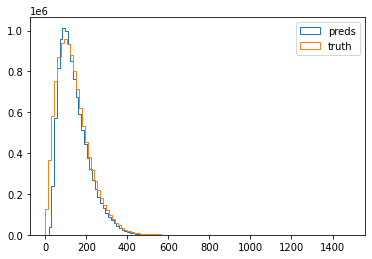

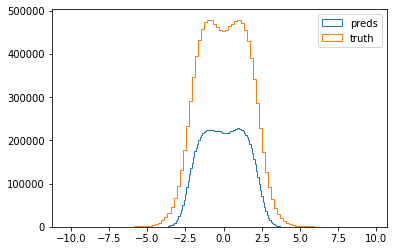

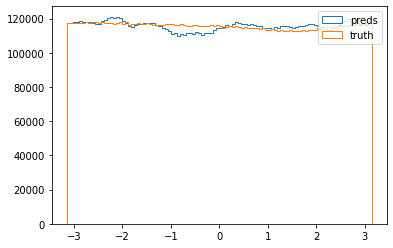

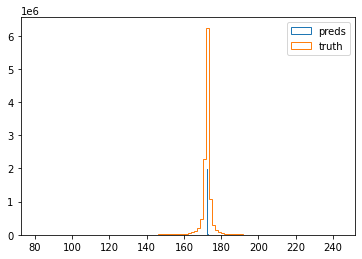

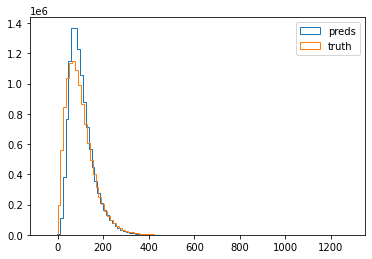

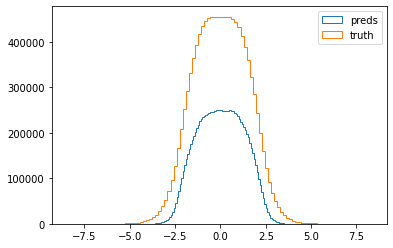

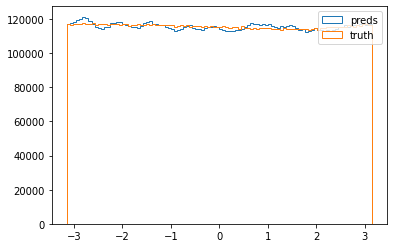

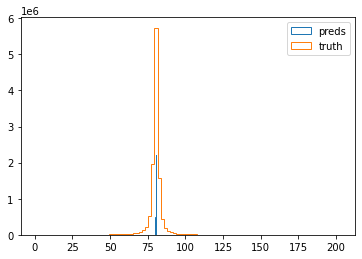

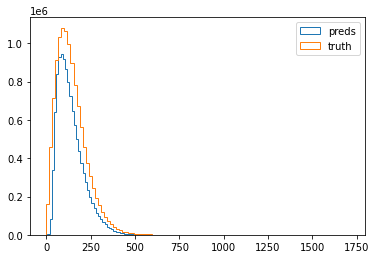

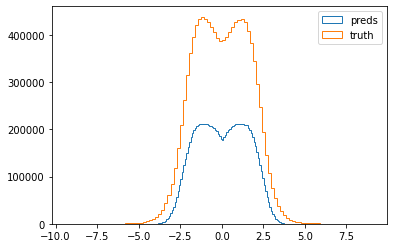

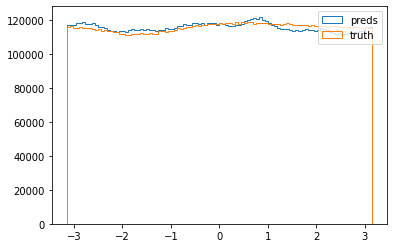

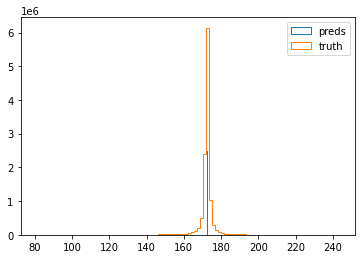

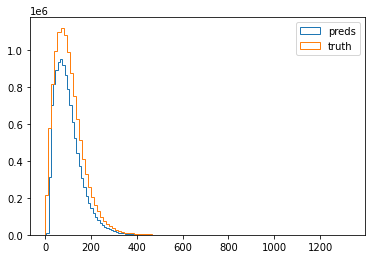

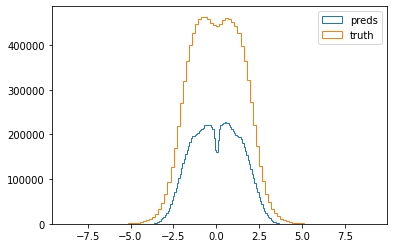

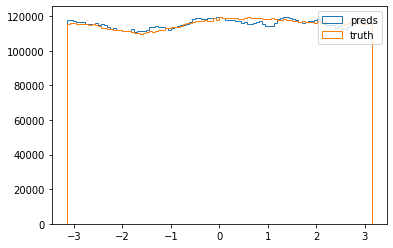

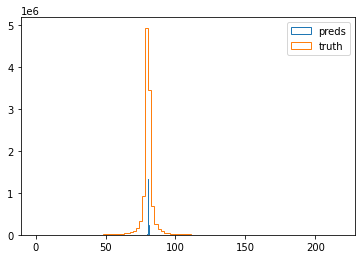

In [3]:
preds = np.load('preds_tao.npy')
truth = np.load('true_tao.npy')

print(len(preds[0]))
print(len(truth[0]))

for i in range(len(truth.T)):
    plt.figure(str(i))
    plt.hist(preds[:,i],bins=100,histtype='step')
    plt.hist(truth[:,i],bins=100,histtype='step')
    plt.legend(['preds','truth'])

16
16


/usr/local/lib/python3.8/dist-packages/numpy/lib/histograms.py:822: RuntimeWarning: divide by zero encountered in double_scalars
  norm = n_equal_bins / _unsigned_subtract(last_edge, first_edge)
/usr/local/lib/python3.8/dist-packages/numpy/lib/histograms.py:850: RuntimeWarning: invalid value encountered in multiply
  f_indices = _unsigned_subtract(tmp_a, first_edge) * norm


IndexError: index -9223372036854775808 is out of bounds for axis 0 with size 101

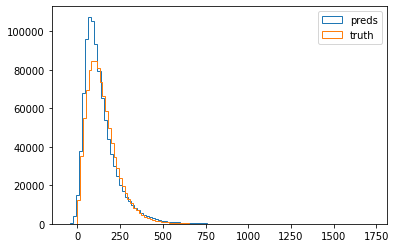

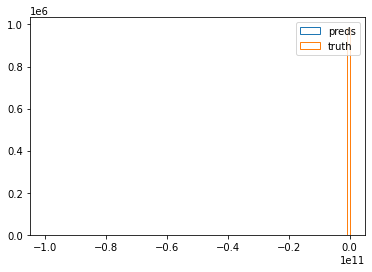

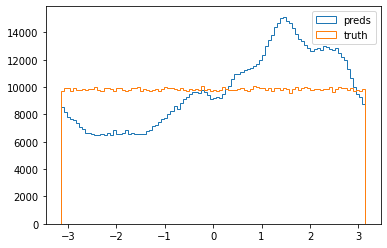

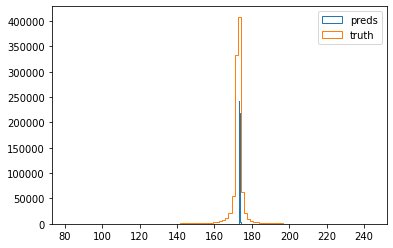

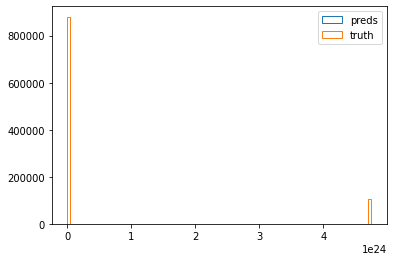

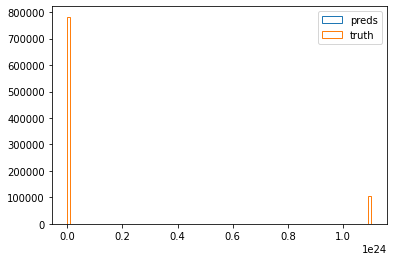

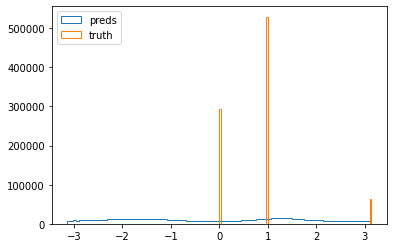

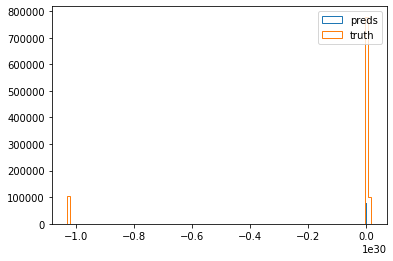

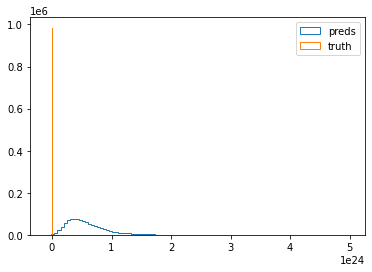

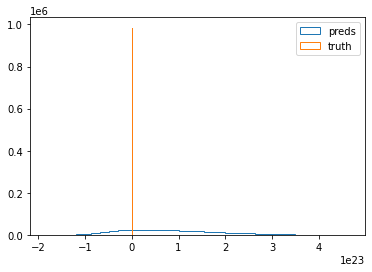

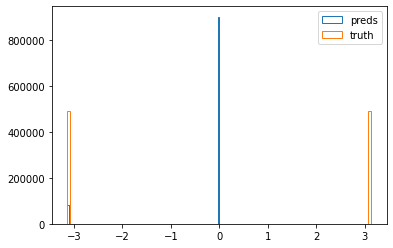

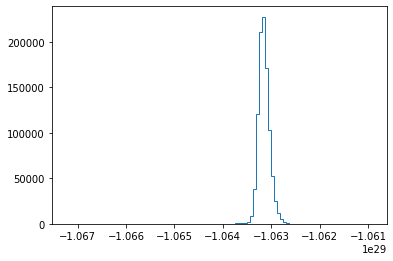

In [3]:
preds = np.load('preds.npy')
truth = np.load('true.npy')

print(len(preds[0]))
print(len(truth[0]))

for i in range(len(truth.T)):
    plt.figure(str(i))
    plt.hist(preds[:,i],bins=100,histtype='step')
    plt.hist(truth[:,i],bins=100,histtype='step')
    plt.legend(['preds','truth'])

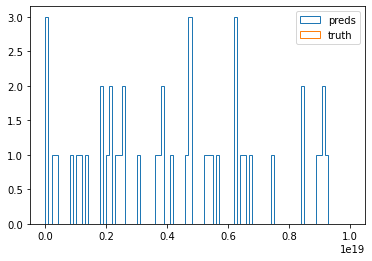

In [22]:
plt.hist(preds[:,9],bins=100,range=(-10,10000000000000000000),histtype='step')
plt.hist(truth[:,9],bins=100,range=(-10,10000000000000000000),histtype='step')
plt.legend(['preds','truth'])